In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from importlib import reload
import model_utils as mu
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import SCORERS
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplot
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
pd.set_option("display.max_rows", 1000)

#### Things I can build with the data

- Data Cleaning
    * For numerical data - examine variables with highest correlation with the missing data - build regression model and make prediction and fill in missing data with predicted value
    * For categorical data - Build a simple classifier and fill in any missing data
- Exploratory data analysis: 
    * Draw standard correlations, heatmaps - that sort of thing
    * Utilise clustering to create groups of people - stratified by age and explore death rate for various sub-groupings
    * Itilise clustering to examine if various groups are more responsive to radio/chemo therapy
- Classification Model Building:
    * Predict overall_survival
    * Tune models utilising grid search CV etc etc to prove ML ability - properly assess models by use of confusion matrices/ROC curves etc.
    * Segment population 
    * After fitting a model, segment the test dataset by probability and observe and interpret correlations
    * Build a model which looks to predict the best course of treatment for an individual given their proteome - 
- Regression Model Building 
    * Predict overall_survival months
- Explore patients who have undergone chemo and their cellularity post chemo - attempt to build an idea of proteome of patient most susceptible to chemo

### List of Important Caveats to mention

- "Death from Cancer" metric -> "died of other causes" - we do not know if these other causes were related to the cancer
- When building model purely from proteomic data, there may be other factors influencing the outcome, it's impossible to normalize/control for this. 

### Questions to ask

- What are the biggest challenges you face in terms of data quality? Is there often data missing?
- What are the biggest challenges you face in general?
- What sort of data sizes are you dealing with on a day to day basis? Big Data or 100's of samples?

### Data Cleaning & Preprocessing

In [31]:
def convert_death_from_cancer(data):
    if data == 'Living' or data == 'Died of Other Causes':
        return 0
    else:
        return 1

In [39]:
data = pd.read_csv('Data/METABRIC_RNA_Mutation.csv')
protein_columns = list(data.select_dtypes(exclude=['object']).columns)[14:]
data.drop(['cancer_type', 'cohort'], axis=1, inplace=True)
data.set_index('patient_id', inplace=True)
nulls = data.isna().sum()[data.isna().sum() > 0]
data = data.infer_objects()
mutation_cols = [x for x in data.columns if 'mut' in x and x != 'mutation_count']
data = pd.concat([data.drop(mutation_cols, 1), pd.get_dummies(data[mutation_cols])], axis=1)
data = data.loc[:,~data.columns.duplicated()]
data.death_from_cancer = data.death_from_cancer.apply(convert_death_from_cancer)

C:\Users\tjs_1\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Building Model to Predict Death From Cancer

- Model building to predict death from cancer based only on the proteomic data. I will assess the model and establish a picture of the most important features in the dataset.

In [41]:
def preprocess_data(data):
    columns_to_impute = ['cancer_type_detailed', 'neoplasm_histologic_grade', 'tumor_other_histologic_subtype', 'primary_tumor_laterality', 'oncotree_code', '3-gene_classifier_subtype', 'tumor_stage']
    data, metrics = mu.data_imputer(data, columns_to_impute)
    data = pd.concat([data.select_dtypes(exclude=['object']), pd.get_dummies(data.select_dtypes('object'))], axis=1)
    data.fillna(-1, inplace=True)
    return data

In [42]:
protein_columns = data.columns[29:]
X, y = data[protein_columns], data.death_from_cancer
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15)
xgb_clf = XGBClassifier(max_depth=5)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
xgb_metrics = mu.assess_model(xgb_clf, X_test, y_test, features=X.columns)

<AxesSubplot:title={'center':'Receiver Operator Characteristic Curve'}, xlabel='FPR', ylabel='TPR'>

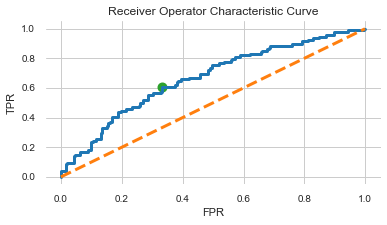

In [50]:
mu.plot_roc_curve(xgb_metrics['roc_curve'], optimal_point=True)

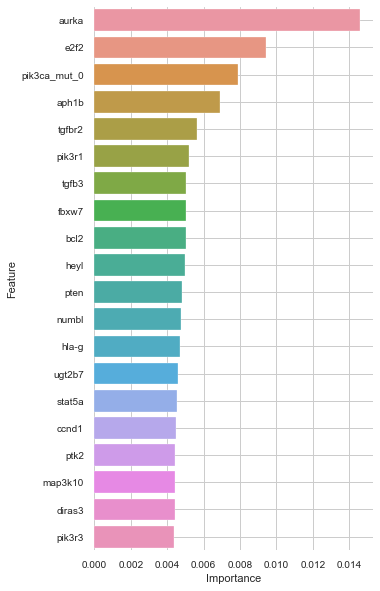

In [51]:
mu.plot_feature_importance(xgb_metrics['feature_importance'], n_features=20)
plt.savefig('Feature_importance.png')

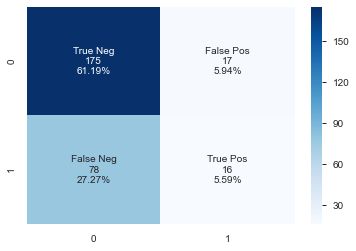

In [52]:
mu.plot_confusion_matrix(xgb_metrics['cf_matrix'])

<AxesSubplot:>

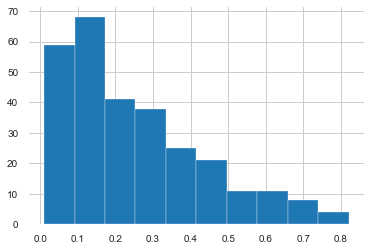

In [55]:
pd.Series(xgb_clf.predict_proba(X_test)[:, 1]).hist()

### Building Model to predict effectiveness of chemo

In [341]:
reload(mu)

<module 'model_utils' from 'C:\\Users\\tjs_1\\OneDrive\\Documents\\Git repos\\Metabric-RNA-Mutation\\model_utils.py'>

In [466]:
def get_cellularity(data):
    if data in ['Low', 'Moderate']:
        return 1
    else:
        return 0

In [467]:
data = pd.read_csv('Data/METABRIC_RNA_Mutation.csv')
data.drop(['cancer_type', 'cohort'], axis=1, inplace=True)
data.set_index('patient_id', inplace=True)

In [468]:
data = data.infer_objects()
data.cellularity = data.cellularity.apply(get_cellularity)
mutation_cols = [x for x in data.columns if 'mut' in x and x != 'mutation_count']
data = pd.concat([data.drop(mutation_cols, 1), pd.get_dummies(data[mutation_cols])], axis=1)
data = data.loc[:,~data.columns.duplicated()]
chemo_data = data[data.chemotherapy == 1].copy()
chemo_data.drop(['overall_survival', 'overall_survival_months', 'chemotherapy', 'death_from_cancer'], 1, inplace=True)

In [470]:
X, y = chemo_data.drop('cellularity', 1), chemo_data.cellularity
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
preprocessor = mu.data_preprocessor()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [471]:
chemo_xgb = XGBClassifier(max_depth=5)
chemo_rf = RandomForestClassifier(n_estimators=1000, max_depth=5)

In [472]:
chemo_xgb.fit(X_train.values, y_train.values) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [473]:
chemo_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [433]:
chemo_xgb_metrics = mu.assess_model(chemo_xgb, X_test.values, y_test.values, binary_target=True, features=X_test.columns, threshold=0.981673)
chemo_rf_metrics = mu.assess_model(chemo_rf, X_test.values, y_test.values, binary_target=True, features=X_test.columns, threshold=0.899191)

C:\Users\tjs_1\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tjs_1\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<AxesSubplot:title={'center':'Receiver Operator Characteristic Curve'}, xlabel='FPR', ylabel='TPR'>

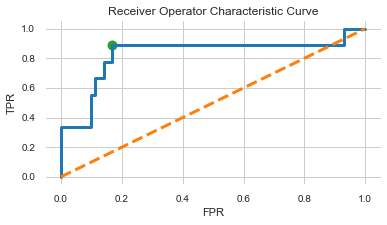

In [474]:
mu.plot_roc_curve(chemo_xgb_metrics['roc_curve'], optimal_point=True)

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

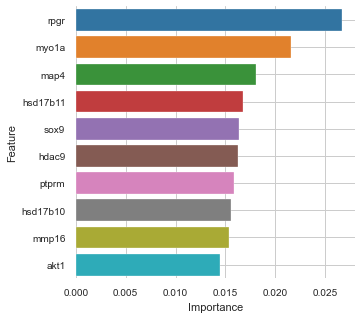

In [489]:
mu.plot_feature_importance(chemo_xgb_metrics['feature_importance'], n_features=10)

#### Applying GridSearchCV for the above RF classifier

In [490]:
param_grid = {'n_estimators': [50, 100, 200, 300, 400, 500, 750, 1000, 1500, 2000], 'max_depth': [2, 4, 5, 6, 8, 10, 15, 20, 25]}
grid_search_rf = GridSearchCV(chemo_rf, param_grid=param_grid, n_jobs=-1, verbose=10, cv=5, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=5,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1000, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='war

In [497]:
chemo_rf_metrics = mu.assess_model(grid_search_rf.best_estimator_, X_test.values, y_test.values, binary_target=True, features=X_test.columns, threshold=0.412229)

<AxesSubplot:title={'center':'Receiver Operator Characteristic Curve'}, xlabel='FPR', ylabel='TPR'>

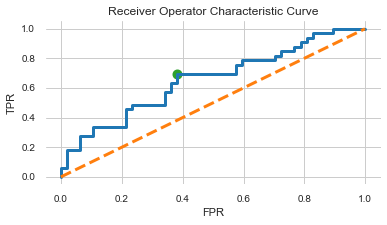

In [498]:
mu.plot_roc_curve(chemo_rf_metrics['roc_curve'], optimal_point=True)

In [500]:
print(chemo_rf_metrics['classification_report'])

              precision    recall  f1-score   support

           0       0.74      0.62      0.67        47
           1       0.56      0.70      0.62        33

    accuracy                           0.65        80
   macro avg       0.65      0.66      0.65        80
weighted avg       0.67      0.65      0.65        80



<AxesSubplot:xlabel='Importance', ylabel='Feature'>

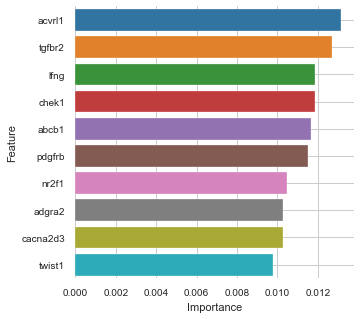

In [501]:
mu.plot_feature_importance(chemo_rf_metrics['feature_importance'], n_features=10)

### Cluster Based Analysis

I will create groupings of individuals based purely on the proteomic data and observe how groupings correlate with death rate.

In [21]:
from mpl_toolkits.mplot3d import Axes3D

In [8]:
protein_data = data[protein_columns]

In [18]:
knn = KMeans(n_clusters=5)
labels = pd.DataFrame(knn.fit_predict(protein_data), index=protein_data.index, columns=['cluster'])
protein_data_with_label = pd.concat([protein_data, labels], 1)
# pca = PCA(2)
# pca_protein_data = pca.fit_transform(protein_data)
# cluster_data = pd.DataFrame(np.concatenate([pca_protein_data, labels.reshape(-1, 1)], axis=1), columns=['dim_1', 'dim_2', 'label'])

In [36]:
pca = PCA(3)
pca_protein_data = pca.fit_transform(protein_data)


In [37]:
pca_protein_data = pd.DataFrame(pca_protein_data)

In [38]:
pca_protein_data = pd.concat([pca_protein_data, data['overall_survival'].reset_index(drop=True)], axis=1)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(protein_data, pca_protein_data['overall_survival'], test_size=0.1, stratify=pca_protein_data['overall_survival'])
xgb = XGBClassifier(max_depth=5)
xgb.fit(X_train, y_train)
accuracy_score(xgb.predict(X_test), y_test)

0.6492146596858639

In [72]:
most_important_protein_data = protein_data[pd.DataFrame(np.array(list(zip(protein_data.columns, xgb.feature_importances_))), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)[:10].Feature]

In [237]:
def get_death_rate(data):
    return (data['death_from_cancer'] == 'Died of Disease').sum() / data.shape[0]

In [238]:
data_ = pd.concat([data, pd.DataFrame(labels, columns=['Cluster'], index=data.index)], axis=1)

In [239]:
data_.Cluster.value_counts()

1    900
0    618
2    386
Name: Cluster, dtype: int64

In [240]:
data_.groupby('Cluster').apply(get_death_rate)

Cluster
0    0.351133
1    0.275556
2    0.409326
dtype: float64